In [1]:
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import tifffile as tiff
from skimage.external import tifffile as sktif
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

In [66]:
from skimage.segmentation import *
from scipy.ndimage.morphology import distance_transform_edt as SDT
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.io import imread_collection
from skimage.measure import regionprops, find_contours
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.morphology import extrema
import cv2

In [4]:
from lovasz_losses import *
def accuracy_pixel(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()


In [3]:
data_dir = Path("/media/wwymak/Storage/urban-3D-satellite")
train_dir = data_dir / "training"
cropped_dir =  data_dir / "cropped_training"
cropped_val_dir =  data_dir / "cropped_validation"
train_cropped_imgs = [f.name for f in (data_dir / "cropped_training").ls() if f.name.endswith('RGB.tif')]
valid_cropped_imgs = [f.name for f in (data_dir / "cropped_validation").ls() if f.name.endswith('RGB.tif')]

dataset_df = pd.DataFrame({"name":[f"cropped_training/{f}" for f in train_cropped_imgs]  \
   + [f"cropped_validation/{f}" for f in valid_cropped_imgs],
   "label": [f"{str(data_dir)}/cropped_training/{f.replace('RGB', 'pytorch_GTL')}" for f in train_cropped_imgs]  \
   + [f"{str(data_dir)}/cropped_validation/{f.replace('RGB', 'pytorch_GTL')}" for f in valid_cropped_imgs],\
        "is_valid":   [False for i in train_cropped_imgs] + [True for i in valid_cropped_imgs ]   })

In [5]:
codes = ["background", "building"]
src = (SegmentationItemList.from_df(dataset_df, path=data_dir )
      . split_from_df(col="is_valid")
       .label_from_df(cols="label", classes=codes))

wd =1e-2
metrics = [accuracy_pixel,dice]

size = 256
bs=32
data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [6]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, loss_func=combined_loss2)
learn.load('lovaz-loss-stage4-ignore-none')
learn.to_fp16();

In [7]:
predict1 = learn.pred_batch()

In [8]:
predict1.shape

torch.Size([32, 2, 256, 256])

In [44]:
test =predict1[7].argmax(dim=0).numpy()
actual_mask = data.valid_dl.y.items[7]

Text(0.5, 1.0, 'actual_mask')

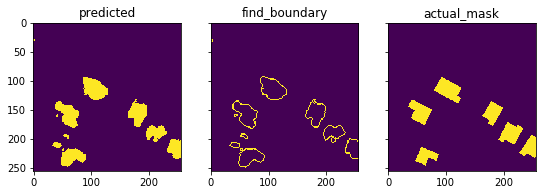

In [54]:
fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(9, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(test)
ax[0].set_title('predicted')
ax[1].imshow(find_boundaries(test))
ax[1].set_title('find_boundary')
ax[2].imshow(sktif.imread(actual_mask))
ax[2].set_title('actual_mask')

In [103]:
boundary_labels = label(find_boundaries(test))
predicted_labels = label(test)                        
len(boundary_labels), len(predicted_labels)

(256, 256)

In [109]:
np.unique(label_image)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

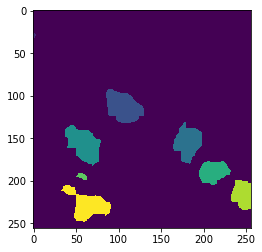

In [112]:
thresh = threshold_otsu(test)
bw = closing(test > thresh, square(10))
cleared = clear_border(bw)
label_image = label(bw)
# image_label_overlay = label2rgb(label_image, image=test)
plt.imshow(label_image)

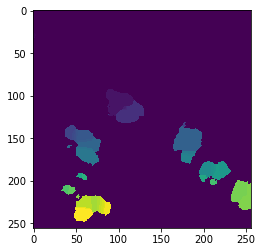

In [52]:
img_properties = regionprops(test)
peaks = [prop.centroid for prop in img_properties]
markers2 = np.zeros((test.shape))
for idx, (peak_r, peak_c) in enumerate(peaks):
    markers2[int(peak_r): int(peak_c)] = idx 
distance_Tranform_test = SDT(test, sampling=0.5)
minima = extrema.h_minima(-distance_Tranform_test, 0)
local_maxi = peak_local_max(distance_Tranform_test, min_distance=50, indices=False, footprint=np.ones((3, 3)),
                            labels=test)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance_Tranform_test, markers, mask=test)
plt.imshow(labels)

In [31]:
img_properties

The current problem becomes one of going from segmantation classes to instances is not so good. 

In [71]:
actual_mask = sktif.imread(data.valid_dl.y.items[7])
contours = find_contours(actual_mask, 0.5)
rects = [cv2.minAreaRect(cnt) for cnt in contours]
boxes = [cv2.boxPoints(rect) for rect in rects]
boxes = [np.int0(box) for box in boxes]
# cv2.drawContours(img,[box],0,(0,0,255),2)

# rect = cv2.minAreaRect(cnts[0])
# if rect[1][1]>rect[1][0]:
#     angle = 90-rect[2]
# else:
#     angle = -rect[2]
# box = cv2.boxPoints(rect)
# #print (box)
# box = np.int0(box)
# img_1 = actual_mask.copy()
# cv2.drawContours(img_1,[box],0,(0,191,255),2)
# x = int(rect[0][0])
# y = int(rect[0][1])

# ax1.imshow(actual_mask)
# ax1.set_title('Image')
# ax2.set_title('Mask')
# ax3.set_title('Image with derived bounding box')
# ax2.imshow(mask_0[...,0], cmap='gray')
# ax3.imshow(img_1)
# plt.show()

fig, ax = plt.subplots()
ax.imshow(actual_mask, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/convhull.cpp:137: error: (-215:Assertion failed) total >= 0 && (depth == CV_32F || depth == CV_32S) in function 'convexHull'


In [100]:
# img = (255*cv2.imread(data.valid_dl.y.items[7]))
img = sktif.imread(data.valid_dl.y.items[7])
# cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [101]:
rects = [cv2.minAreaRect(cnt) for cnt in contours]
boxes = [cv2.boxPoints(rect) for rect in rects]
boxes = [np.int0(box) for box in boxes]

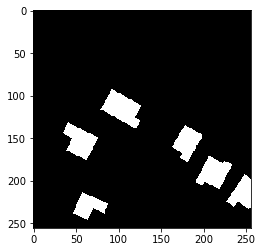

In [94]:
plt.imshow(img)

In [98]:
len(x)

2

In [102]:
cv2.drawContours??